# TRY MORE WINDOWS
# IF peaks collide, take the bigger one (remove these peaks altogther?)


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing
import sys
import logging

tf.get_logger().setLevel(logging.ERROR)

sys.path.append('../src/')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

np.set_printoptions(suppress=True)

In [2]:
# import modules
from cnn.simulator import Simulator

from cnn.models import ConvNet
from cnn.losses import CustomLoss
from cnn.metrics import CustomAUC
from cnn.preprocessing import LabelEncoder
from cnn.data_generators import DataGenerator

In [3]:
# def a(x, amplitude, loc, scale, asymmetry):
#     # assymetrical_gaussian_peak(..., assymetry=0) is the same as gaussian_peak(...)
#     # add additional asymmetries by adding to the denominator inside np.exp:
#     #   scale + asymmetry*(x-loc) + asymmetry*(x-loc)**2 ...,
#     return amplitude * np.exp(-1/2*((x - loc)/(scale + asymmetry*(x - loc)))**2)

# x = np.linspace(0, 1, 1000)
# plt.plot(a(x, 50, 0.5, 0.05, 0.15))
# plt.plot(a(x, 50, 0.5, 0.04, 0.15))
# plt.plot(a(x, 50, 0.5, 0.03, 0.15))
# plt.plot(a(x, 50, 0.5, 0.02, 0.15))
# plt.plot(a(x, 50, 0.5, 0.01, 0.15))
# plt.xlim(350, 800)

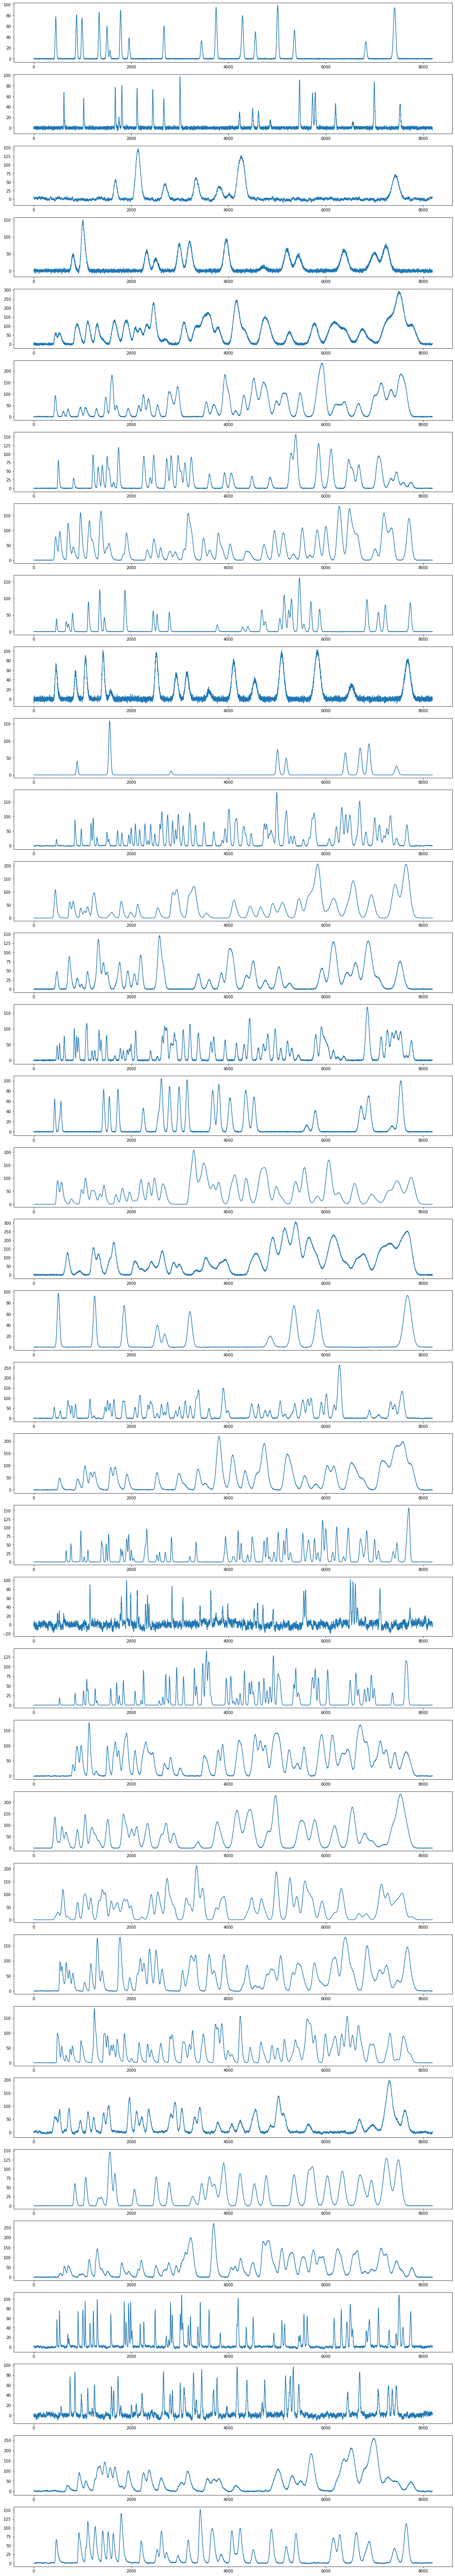

In [4]:
simulator_train = Simulator(LabelEncoder(512).remove_collision)

fig, axes = plt.subplots(36, 1, figsize=(20, 120))
for i in range(36):
    x = simulator_train._generate_example(i+100)['chromatogram']
    axes.reshape(-1)[i].plot(x)
   # axes.reshape(-1)[i].set_xlim(5000, 7500)
   # axes.reshape(-1)[i].set_ylim(-2, 2)

In [5]:

# Model training
NUM_TRAIN_EXAMPLES = int(1e6)
NUM_TEST_EXAMPLES = int(1e4)
BATCH_SIZE = 32
STEPS_PER_EPOCH = 1e5 // BATCH_SIZE
NUM_EPOCHS = 10

# Model optimizer
INITIAL_LEARNING_RATE = 1e-3
END_LEARNING_RATE = 1e-5
DECAY_STEPS = int(STEPS_PER_EPOCH / BATCH_SIZE * NUM_EPOCHS)

# Label encoder
NUM_CLASSES = 3
NUM_WINDOWS = 256
INPUT_SIZE = 8192


# Define loss function, optimizer and metrics
loss_fn = CustomLoss(NUM_CLASSES, 1.0, 1.0, 1.0)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=INITIAL_LEARNING_RATE, 
        decay_steps=DECAY_STEPS, 
        end_learning_rate=END_LEARNING_RATE
    )
)

metrics = [CustomAUC(NUM_CLASSES)]

# Define data generators 
# Simulator uses method of label_encoder to deal with collisions
label_encoder = LabelEncoder(NUM_WINDOWS)
train_generator = DataGenerator(
    np.arange(0, NUM_TRAIN_EXAMPLES), 
    simulator=Simulator(label_encoder.remove_collision, resolution=INPUT_SIZE), 
    label_encoder=label_encoder,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = DataGenerator(
    np.arange(NUM_TRAIN_EXAMPLES, NUM_TRAIN_EXAMPLES + NUM_TEST_EXAMPLES), 
    simulator=Simulator(label_encoder.remove_collision, resolution=INPUT_SIZE), 
    label_encoder=label_encoder,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model = ConvNet(
    filters=[128, 128, 256, 256, 512],
    kernel_sizes=[9, 9, 9, 9, 9],
    pool_type='conv',
    conv_block_size=1,
    input_shape=(INPUT_SIZE, 1),
    output_shape=(NUM_WINDOWS, NUM_CLASSES)
)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [6]:
model.fit(
    train_generator, validation_data=test_generator,
    epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
)


Epoch 1/10
3125/3125 [==============================] - 1075s 342ms/step - loss: 1.0409 - AUC: 0.9770 - val_loss: 0.8754 - val_AUC: 0.9885
Epoch 2/10
3125/3125 [==============================] - 1061s 339ms/step - loss: 0.9059 - AUC: 0.9871 - val_loss: 0.8652 - val_AUC: 0.9893
Epoch 3/10
3125/3125 [==============================] - 1050s 336ms/step - loss: 0.8945 - AUC: 0.9879 - val_loss: 0.8580 - val_AUC: 0.9897
Epoch 4/10
3125/3125 [==============================] - 1068s 342ms/step - loss: 0.8876 - AUC: 0.9884 - val_loss: 0.8506 - val_AUC: 0.9901
Epoch 5/10
3125/3125 [==============================] - 1099s 352ms/step - loss: 0.8818 - AUC: 0.9888 - val_loss: 0.8483 - val_AUC: 0.9904
Epoch 6/10
3125/3125 [==============================] - 1085s 347ms/step - loss: 0.8735 - AUC: 0.9893 - val_loss: 0.8479 - val_AUC: 0.9906
Epoch 7/10
1023/3125 [========>.....................] - ETA: 11:29 - loss: 0.8727 - AUC: 0.9893

KeyboardInterrupt: 

In [7]:
prediction = model.predict(test_generator, verbose=1, use_multiprocessing=True, workers=10)

313/313 [==============================] - 26s 81ms/step


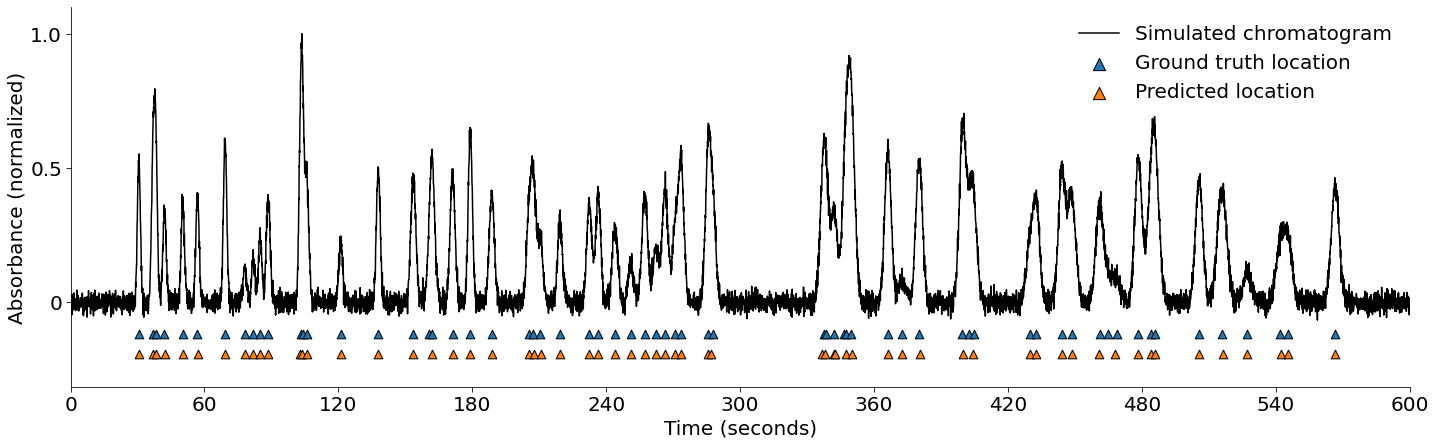

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(24, 7))

x_lim = [0.0, 1.0 + 1e-7]

ID = 12

true_move = {0: (0.0, 0), 1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0), 
             5: (0, 0), 6: (0, 0), 7: (0, 0), 8: (0, 0), 9: (0, 0), 
             10: (0, 0), }

pred_move = {0: (0, 0), 1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0), 
             5: (0, 0), 6: (0.03, 0), 7: (-0.005, 15), 8: (0, 0), 9: (0.03, 0), 
             10: (0, 15), }


# GROUND TRUTH
true = test_generator.__getitem__(ID)

pred = prediction[ID*test_generator.batch_size]

probs, locs, areas = label_encoder.decode(pred, 0.4)

x = true[0][0]
y = true[1][0]
x *= 200

gt = label_encoder.decode(y)

j, k = 0, 0

for i, y_sample in enumerate(y):
    if y_sample[0] == 1:
        
        index = int(gt[1][k] * INPUT_SIZE)
        height = max(x[index:index+1]) + 5
        
        if x_lim[0] < gt[1][k] < x_lim[1]: 
            ax.scatter(gt[1][k], np.min(x)-10, c='C0', s=75, marker='^', edgecolor='black')
        
        k += 1
        
    if pred[i][0] > 0.4:
        index = int(gt[1][k-1] * INPUT_SIZE)
        height = max(x[index:index+1]) + 5
        
        if x_lim[0] < locs[j] < x_lim[1]: 
            
            ax.scatter(locs[j], np.min(x)-25, c='C1', s=75, marker='^', edgecolor='black')
        
        
        j += 1
        
   
ax.plot(np.linspace(0, 1, INPUT_SIZE), x, c='black', label='Simulated chromatogram')
        
ax.scatter([None],[None], c='C0', marker='^', s=150, edgecolor='black', label='Ground truth location')
ax.scatter([None],[None], c='C1', marker='^', s=150, edgecolor='black', label='Predicted location')


ax.set_ylabel('Absorbance (normalized)', fontsize=20)
ax.set_xlabel('Time (seconds)', fontsize=20)
ax.set_xticklabels([0*60, 1*60, 2*60, 3*60, 4*60, 5*60, 6*60, 7*60, 8*60, 9*60, 10*60])
ax.set_ylim(np.min(x)-50, np.max(x)+20);
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_xlim(*x_lim)
ax.tick_params(axis='both', length=5, labelsize=20)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 0.1))
ax.set_yticks([0, 100, 200])
ax.set_yticklabels([0,  100/200,  200/200])
start, end = ax.get_ylim()
ax.legend(fontsize=20, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('Figure_3a.png', dpi=200)

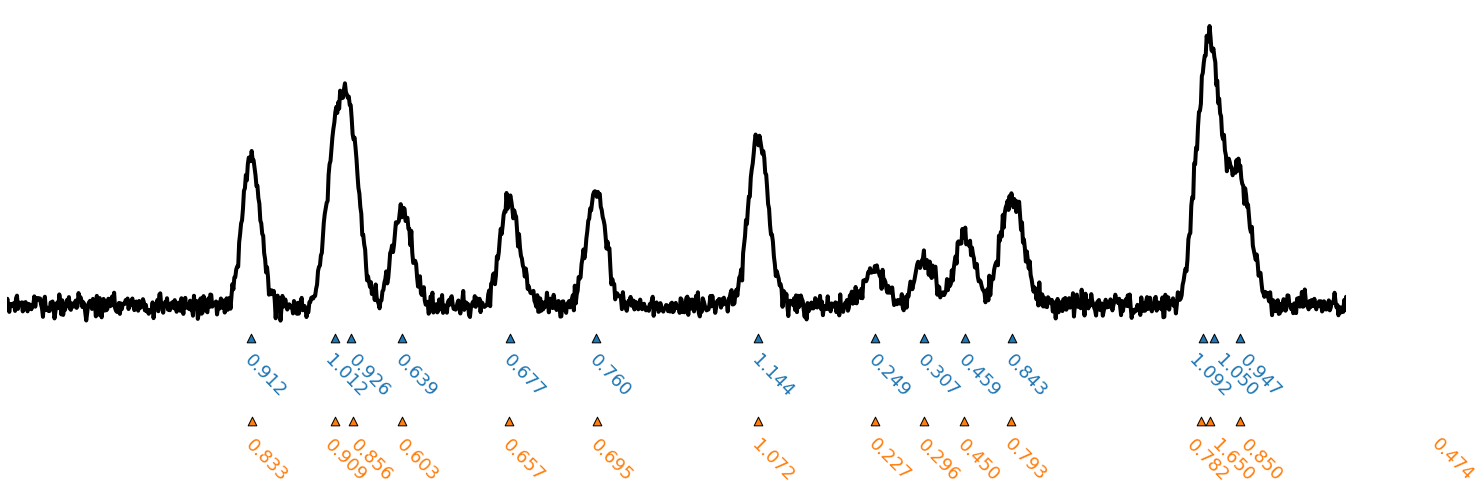

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(24, 8))

x_lim = [0.0, 1.0 + 1e-7]

ID = 12

true_move = {0: (0.0, 0), 1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0), 
             5: (0, 0), 6: (0, 0), 7: (0, 0), 8: (0, 0), 9: (0, 0), 
             10: (0, 0), }

pred_move = {0: (0, 0), 1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0), 
             5: (0, 0), 6: (0.03, 0), 7: (-0.005, 15), 8: (0, 0), 9: (0.03, 0), 
             10: (0, 15), }


# GROUND TRUTH
true = test_generator.__getitem__(ID)

pred = prediction[ID*test_generator.batch_size]

probs, locs, areas = label_encoder.decode(pred, 0.4)

x = true[0][0]
y = true[1][0]
x *= 200

gt = label_encoder.decode(y)

j, k = 0, 0
for i, y_sample in enumerate(y):
    
    
    
    
    if y_sample[0] == 1:
        
        if k == 11:
            move = 0.001
        elif k == 12:
            move = -0.001
        elif k == 13:
            move = -0.0008
        elif k == 1:
            move = 0.0005
        elif k == 2:
            move = -0.0005
        else:
            move = 0
        
        index = int(gt[1][k] * INPUT_SIZE)
        if np.linspace(0, 1, INPUT_SIZE)[index] > 0.19:
            continue
            
        height = max(x[index:index+1]) + 5
        
        if x_lim[0] < gt[1][k] < x_lim[1]: 
            ax.scatter(gt[1][k], np.min(x)-10, c='C0', s=75, marker='^', edgecolor='black')
            #ax.axvline(gt[1][k], linestyle='--')
            #if k % 3 == 0:
            ax.text(x=gt[1][k]-0.00125 * (x_lim[1] - x_lim[0]) - move, y=-65, 
                    s=f"{gt[2][k]:.3f}", rotation=-46, color="C0", fontsize=18)
        
        k += 1
    
    index = int(gt[1][k-1] * INPUT_SIZE)
    if np.linspace(0, 1, INPUT_SIZE)[index] > 0.18:
        continue
            
    if pred[i][0] > 0.4:
            
        height = max(x[index:index+1]) + 5
        
        if x_lim[0] < locs[j] < x_lim[1]: 
            
            ax.scatter(locs[j], np.min(x)-70, c='C1', s=75, marker='^', edgecolor='black')
            ax.text(x=locs[j]-0.00125 * (x_lim[1] - x_lim[0]) - move, y=-125, 
                    s=f"{areas[j]:.3f}", rotation=-45, color='C1', fontsize=18)

#             ax.text(x=locs[j]-0.00125 * (x_lim[1] - x_lim[0]) - move, y=-173, 
#                     s=f"          (p={probs[j]:.3f})", rotation=-45, color='black', fontsize=18)
            
            
        j += 1
        
        
ax.plot(np.linspace(0, 1, INPUT_SIZE), x, c='black', linewidth=4)

ax.set_xlim(0.02, 0.19)

ax.axis('off')

plt.savefig('Figure_3b.png', dpi=200)

In [226]:

avg_error = []
for ID in range(20):
    
    true = test_generator.__getitem__(ID)
    
    pred = prediction[ID*test_generator.batch_size]

    probs, locs, areas = label_encoder.decode(pred, 0.4)
    
    y = true[1][0]
    
    gt = label_encoder.decode(y)

    j, k = 0, 0
    for i, y_sample in enumerate(y):
    
    

        if y_sample[0] == 1:

            k += 1


        if pred[i][0] > 0.4:

            error = abs(gt[2][k-1] - areas[j]) / gt[2][k-1] 
            avg_error.append(error)

            j += 1
            
np.mean(avg_error)

0.1920497913130657

In [155]:
import scipy.interpolate
import glob
import pandas as pd

In [156]:
def apply_interpolation(x, y, target_size):
    '''
    Resizes a chromatogram to a given size/resolution
    '''
    f = scipy.interpolate.interp1d(x, y)
    xnew = np.linspace(x.min(), x.max(), target_size)
    ynew = f(xnew)
    return xnew, ynew

def apply_interpolation(y, target_size):
    '''
    Resizes a chromatogram to a given size/resolution
    '''
    x = np.linspace(0, 1, len(y))
    f = scipy.interpolate.interp1d(x, y)
    xnew = np.linspace(0, 1, target_size)
    ynew = f(xnew)
    return ynew

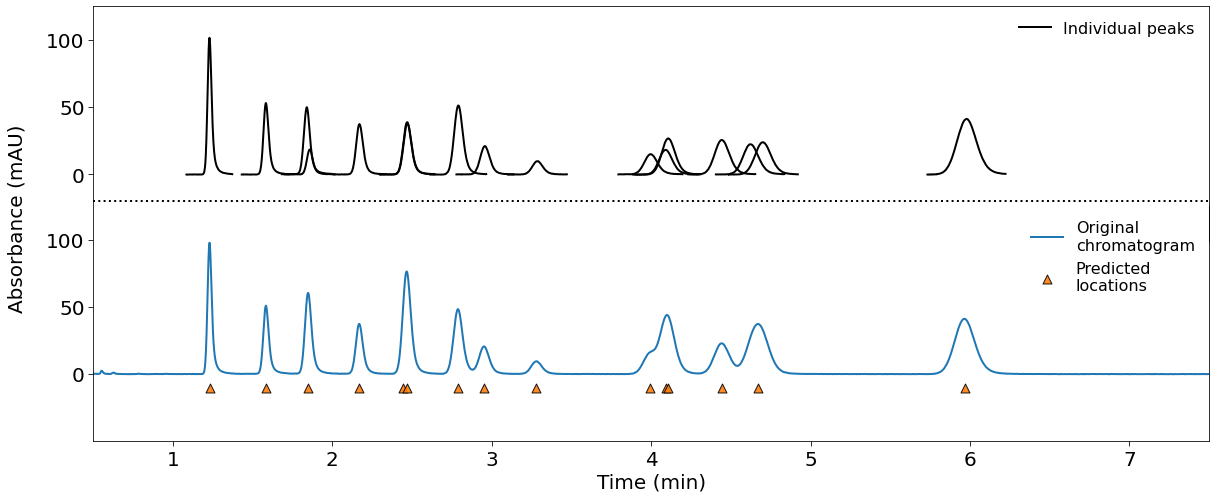

In [201]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

chromatogram_path = '../input/ISO40_mixed/MIX_ISO40.CSV'
peaks_path = glob.glob('../input/ISO40_mixed/[XVI0-9]*.CSV')
multiplier = 1.5

data = pd.read_csv(chromatogram_path, header=None, sep='\t', encoding='utf-16')
chromatogram = data.iloc[:, 1].values
chromatogram = apply_interpolation(chromatogram, INPUT_SIZE)

chromatogram = chromatogram[None, :, None] 
max_ = chromatogram.max()
chromatogram /= max_
predictions = model.predict(chromatogram)[0]
chromatogram *= max_

# CHROMATOGRAM
axes[1].plot(np.linspace(0, 1, INPUT_SIZE), chromatogram[0, :, 0], c='C0', linestyle='-', linewidth=2, label='Original\nchromatogram')

# INDIVIDUAL PEAKS
for j, path in enumerate(peaks_path):
    data = pd.read_csv(path, header=None, sep='\t', encoding='utf-16')
    signal = apply_interpolation(data.iloc[:, 1].values, INPUT_SIZE)
    i = np.argmax(signal)
    extra = 1 + (i / INPUT_SIZE)
    shift = int(100 * extra**1.5)
    axes[0].plot(np.linspace(0, 1, INPUT_SIZE)[i-shift: i+shift], signal[i-shift: i+shift], c=f'black', 
                 linestyle='-', linewidth=2, 
                 label='Individual peaks' if j == 0 else None)
        
move = [0, 0, -0.0035, 0.0035, 0, -0.003, 0.003, 0, 0, 0, -0.00, -0.0015, 0.0055, 0, -0.0015, 0.004, 0]
# PREDICTIONS (ADD LABELS)
probs, locs, areas = label_encoder.decode(predictions, 0.4)
for i, (prob, loc, area) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(loc, -10, marker='^', s=80, alpha=0.9, edgecolors='black', c=f'C1', label="Predicted\nlocations" if i == 0 else None)
    #axes[1].text(x=loc-0.005+move[i], y=-40, s=f'{prob:.3f}', rotation=-45)
    
   # axes[1].text(x=loc-0.005+move[i], y=-40, s=f'{area*max_:.3f}', rotation=-45)
    #print(loc)
   # axes[1].axvline(loc, c='C1', linestyle='--', linewidth=2)
   # axes[0].axvline(loc, c='C1', linestyle='--', linewidth=2)


# MODIFY PLOTS
axes[0].set_xlim(0.05, 0.75)
axes[1].set_xlim(0.05, 0.75)

axes[0].tick_params(
    axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)

axes[0].set_ylim(-50, 125)
axes[1].set_ylim(-50, 125)
axes[0].axhline(-20, color='black', linestyle=':', linewidth=2)
axes[0].set_yticks([0, 50, 100])
axes[1].set_yticks([0, 50, 100])

axes[0].tick_params(
    axis='y', which='both', bottom=False, top=False, labelbottom=False, labelsize=20, length=5)

axes[1].tick_params(
    axis='both', which='both',labelsize=20, length=5)

start, end = axes[0].get_xlim()
#axes[1].set_xticklabels(np.round(np.linspace(start.round(1), end.round(1), 11) * 10, 2))
axes[1].set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

axes[1].set_xlabel('Time (min)', fontsize=20)

axes[0].set_ylabel('Absorbance (mAU)', fontsize=20)
axes[0].yaxis.set_label_coords(-0.06, 0.1)

axes[1].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)
axes[0].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)

plt.subplots_adjust(hspace=-0.15)

plt.savefig('Figure_4_.png', dpi=200)


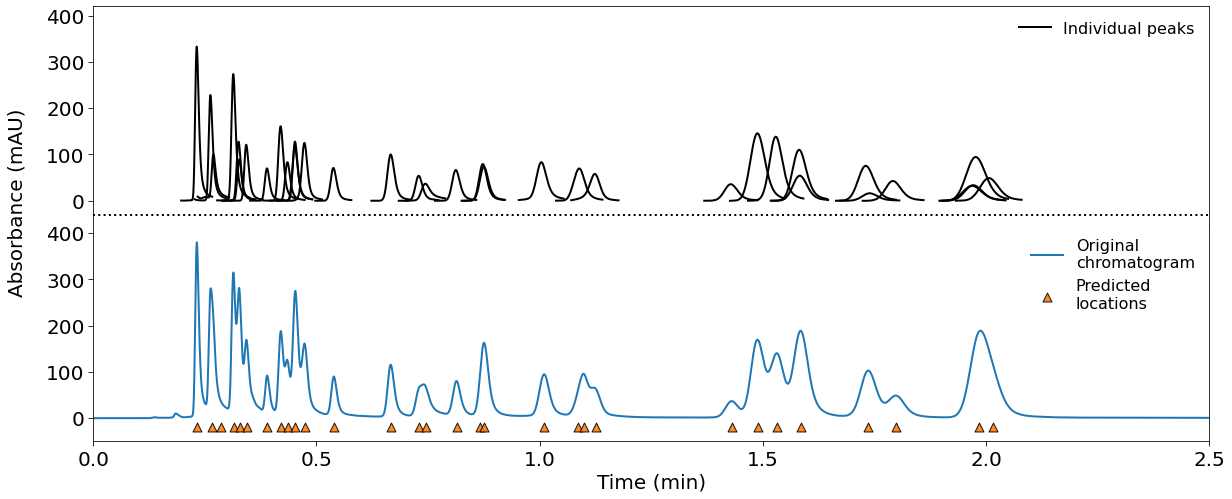

In [200]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

chromatogram_path = '../input/ISO30B_mixed/MIX_ISO30B.CSV'
peaks_path = glob.glob('../input/ISO30B_mixed/[XVIL0-9]*.CSV')
multiplier = 1.5

data = pd.read_csv(chromatogram_path, header=None, sep='\t', encoding='utf-16')
chromatogram = data.iloc[:, 1].values
chromatogram = apply_interpolation(chromatogram, INPUT_SIZE)

chromatogram = chromatogram[None, :, None] 
max_ = chromatogram.max()
chromatogram /= max_
predictions = model.predict(chromatogram)[0]
chromatogram *= max_

# CHROMATOGRAM
axes[1].plot(np.linspace(0, 1, INPUT_SIZE), chromatogram[0, :, 0], c='C0', linestyle='-', linewidth=2, label='Original\nchromatogram')

# INDIVIDUAL PEAKS
for j, path in enumerate(peaks_path):
    data = pd.read_csv(path, header=None, sep='\t', encoding='utf-16')
    signal = apply_interpolation(data.iloc[:, 1].values, INPUT_SIZE)
    i = np.argmax(signal)
    extra = 1 + (i / INPUT_SIZE)
    shift = int(100 * extra**1.5)
    axes[0].plot(np.linspace(0, 1, INPUT_SIZE)[i-shift: i+shift], signal[i-shift: i+shift], c=f'black', 
                 linestyle='-', linewidth=2, 
                 label='Individual peaks' if j == 0 else None)
        
move = [0, 0, -0.0035, 0.0035, 0, -0.003, 0.003, 0, 0, 0, -0.00, -0.0015, 0.0055, 0, -0.0015, 0.004, 0]
# PREDICTIONS (ADD LABELS)
probs, locs, areas = label_encoder.decode(predictions, 0.5)
for i, (prob, loc, area) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(loc, -20, marker='^', s=80, alpha=0.9, edgecolors='black', c=f'C1', label="Predicted\nlocations" if i == 0 else None)


# MODIFY PLOTS
axes[0].set_xlim(0.0, 1.00)
axes[1].set_xlim(0.0, 1.00)

axes[0].tick_params(
    axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)

axes[0].set_ylim(-50, 420)
axes[1].set_ylim(-50, 420)
axes[0].axhline(-30, color='black', linestyle=':', linewidth=2)
axes[0].set_yticks([0, 100, 200, 300, 400])
axes[1].set_yticks([0, 100, 200, 300, 400])

axes[0].tick_params(
    axis='y', which='both', bottom=False, top=False, labelbottom=False, labelsize=20, length=5)

axes[1].tick_params(
    axis='both', which='both',labelsize=20, length=5)

start, end = axes[0].get_xlim()
#axes[1].set_xticklabels([0,1,2,3,4,5,6,7,8,9])
axes[1].set_xticklabels([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
#axes[1].set_xtickslabels([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
axes[1].set_xlabel('Time (min)', fontsize=20)

axes[0].set_ylabel('Absorbance (mAU)', fontsize=20)
axes[0].yaxis.set_label_coords(-0.06, 0.1)

axes[1].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)
axes[0].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)

plt.subplots_adjust(hspace=-0.0)

plt.savefig('Figure_6_.png', dpi=200)


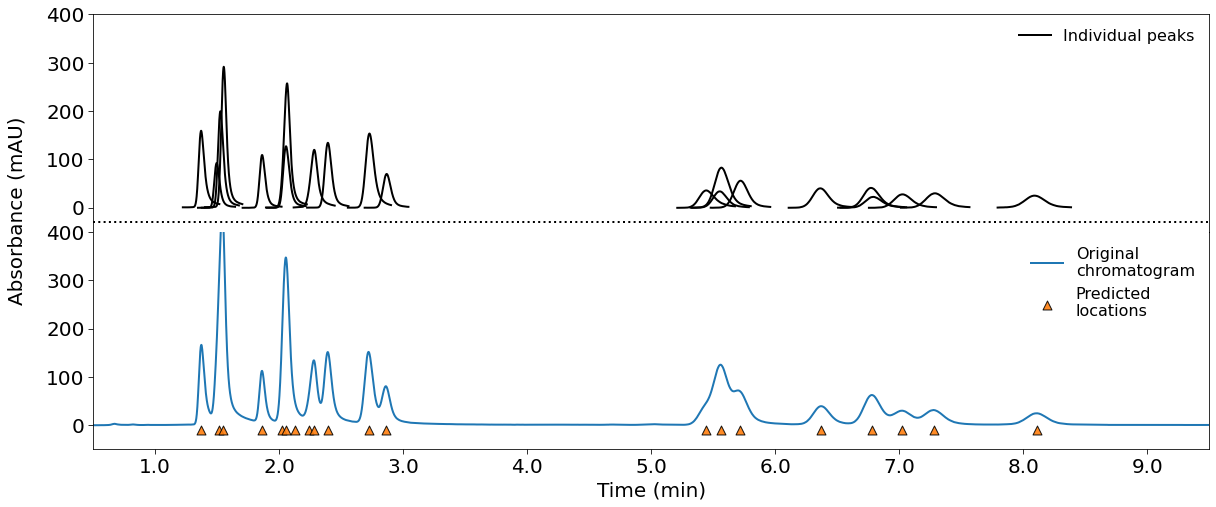

In [199]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

chromatogram_path = '../input/ISO10_mixed/MIX_ISO10.CSV'
peaks_path = glob.glob('../input/ISO10_mixed/[XVIL0-9]*.CSV')
multiplier = 1.5

data = pd.read_csv(chromatogram_path, header=None, sep='\t', encoding='utf-16')
chromatogram = data.iloc[:, 1].values
chromatogram = apply_interpolation(chromatogram, INPUT_SIZE)

chromatogram = chromatogram[None, :, None] 
max_ = chromatogram.max()
chromatogram /= max_
predictions = model.predict(chromatogram)[0]
chromatogram *= max_

# CHROMATOGRAM
axes[1].plot(np.linspace(0, 1, INPUT_SIZE), chromatogram[0, :, 0], c='C0', linestyle='-', linewidth=2, label='Original\nchromatogram')

# INDIVIDUAL PEAKS
for j, path in enumerate(peaks_path):
    data = pd.read_csv(path, header=None, sep='\t', encoding='utf-16')
    signal = apply_interpolation(data.iloc[:, 1].values, INPUT_SIZE)
    i = np.argmax(signal)
    extra = 1 + (i / INPUT_SIZE)
    shift = int(100 * extra**1.5)
    axes[0].plot(np.linspace(0, 1, INPUT_SIZE)[i-shift: i+shift], signal[i-shift: i+shift], c=f'black', 
                 linestyle='-', linewidth=2, 
                 label='Individual peaks' if j == 0 else None)
        
move = [0, 0, -0.0035, 0.0035, 0, -0.003, 0.003, 0, 0, 0, -0.00, -0.0015, 0.0055, 0, -0.0015, 0.004, 0]
# PREDICTIONS (ADD LABELS)
probs, locs, areas = label_encoder.decode(predictions, 0.5)
for i, (prob, loc, area) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(loc, -10, marker='^', s=80, alpha=0.9, edgecolors='black', c=f'C1', label="Predicted\nlocations" if i == 0 else None)


# MODIFY PLOTS
axes[0].set_xlim(0.05, 0.95)
axes[1].set_xlim(0.05, 0.95)

axes[0].tick_params(
    axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].spines['top'].set_visible(False)

axes[0].set_ylim(-50, 400)
axes[1].set_ylim(-50, 400)
axes[0].axhline(-30, color='black', linestyle=':', linewidth=2)
axes[0].set_yticks([0, 100, 200, 300, 400])
axes[1].set_yticks([0, 100, 200, 300, 400])

axes[0].tick_params(
    axis='y', which='both', bottom=False, top=False, labelbottom=False, labelsize=20, length=5)

axes[1].tick_params(
    axis='both', which='both',labelsize=20, length=5)

start, end = axes[0].get_xlim()
axes[1].set_xticklabels(np.round(np.linspace(start.round(1), end.round(1), 11) * 10, 2))
axes[1].set_xlabel('Time (min)', fontsize=20)

axes[0].set_ylabel('Absorbance (mAU)', fontsize=20)
axes[0].yaxis.set_label_coords(-0.06, 0.1)

axes[1].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)
axes[0].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)

plt.subplots_adjust(hspace=-0.0)

plt.savefig('Figure_7_.png', dpi=200)


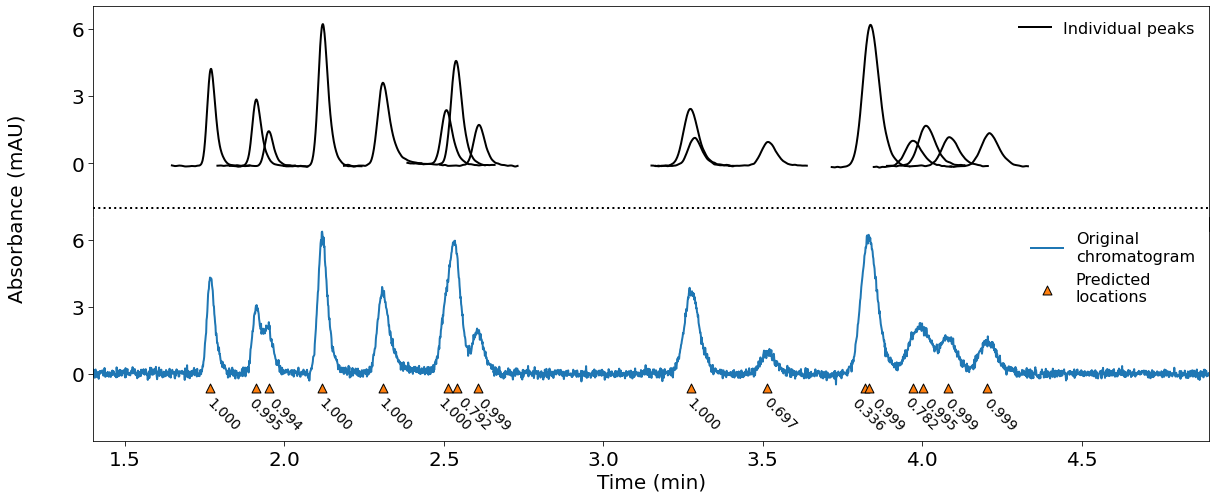

In [202]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

data = pd.read_csv('../input/chrom_1/ISO_ALL_F160.CSV', header=None, sep='\t', encoding='utf-16')
chromatogram = data.iloc[:, 1].values
chromatogram = apply_interpolation(chromatogram, INPUT_SIZE)

chromatogram = chromatogram[None, :, None] 
max_ = chromatogram.max()
chromatogram /= max_
predictions = model.predict(chromatogram)[0]
chromatogram *= max_ 

# CHROMATOGRAM
axes[1].plot(np.linspace(0, 1, INPUT_SIZE), chromatogram[0, :, 0], c='C0', linestyle='-', linewidth=2, label='Original\nchromatogram')

# INDIVIDUAL PEAKS
for j, path in enumerate(glob.glob('../input/chrom_1/ISO_[0-9]*')):
    data = pd.read_csv(path, header=None, sep='\t', encoding='utf-16')
    signal = apply_interpolation(data.iloc[:, 1].values, INPUT_SIZE) 
    i = np.argmax(signal)
    axes[0].plot(np.linspace(0, 1, INPUT_SIZE)[i-100: i+100], signal[i-100: i+100], c=f'black', linewidth=2, 
                 label='Individual peaks' if j == 0 else None)
    


move = [0, -0.0012, 0.0012, 0, 0, -0.002, 0.0013, 0.0012, 0, 0, -0.003, 0.002, -0.0015, 0.0012, 0, 0]
# PREDICTIONS (ADD LABELS)
probs, locs, areas = label_encoder.decode(predictions, 0.3)
for i, (prob, loc, area) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(loc, -0.6, marker='^', s=80, edgecolors='black', c=f'C1', label="Predicted\nlocations" if i == 0 else None)
    axes[1].text(x=loc-0.002+move[i], y=-2.5, s=f'{prob:.3f}', rotation=-45, fontsize=14)
    #axes[0].axvline(loc, c='C1', linestyle='--', linewidth=2)
    #axes[1].axvline(loc, c='C1', linestyle='--', linewidth=2)


# MODIFY PLOTS
axes[0].set_xlim(0.14, 0.49)
axes[1].set_xlim(0.14, 0.49)

axes[0].tick_params(
    axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)

axes[0].set_ylim(-90//20, 140//20)
axes[1].set_ylim(-90//20, 140//20)
axes[0].axhline(-2, color='black', linestyle=':', linewidth=2)

axes[0].set_ylim(-3, 7)
axes[1].set_ylim(-3, 7)

axes[0].set_yticks([0, 3, 6])
axes[1].set_yticks([0, 3, 6])

axes[0].tick_params(
    axis='y', which='both', bottom=False, top=False, labelbottom=False, labelsize=20, length=5)

axes[1].tick_params(
    axis='both', which='both',labelsize=20, length=5)


axes[1].set_xticklabels(np.round(np.linspace(0.1, 0.50, 9) * 10, 2))
axes[1].set_xlabel('Time (min)', fontsize=20)

axes[0].set_ylabel('Absorbance (mAU)', fontsize=20)
axes[0].yaxis.set_label_coords(-0.06, 0.1)

axes[1].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)
axes[0].legend(bbox_to_anchor=(0, 0, 1, 1), ncol=1, columnspacing=0, fontsize=16, frameon=False)

plt.subplots_adjust(hspace=-0.06)


plt.savefig('Figure_5_.png', dpi=200)

move = [0, -0.0012, 0.0012, 0, 0, -0.0012, 0.0012, 0.0012, 0, 0, -0.002, 0.002, -0.0012, 0.0012, 0, 0]

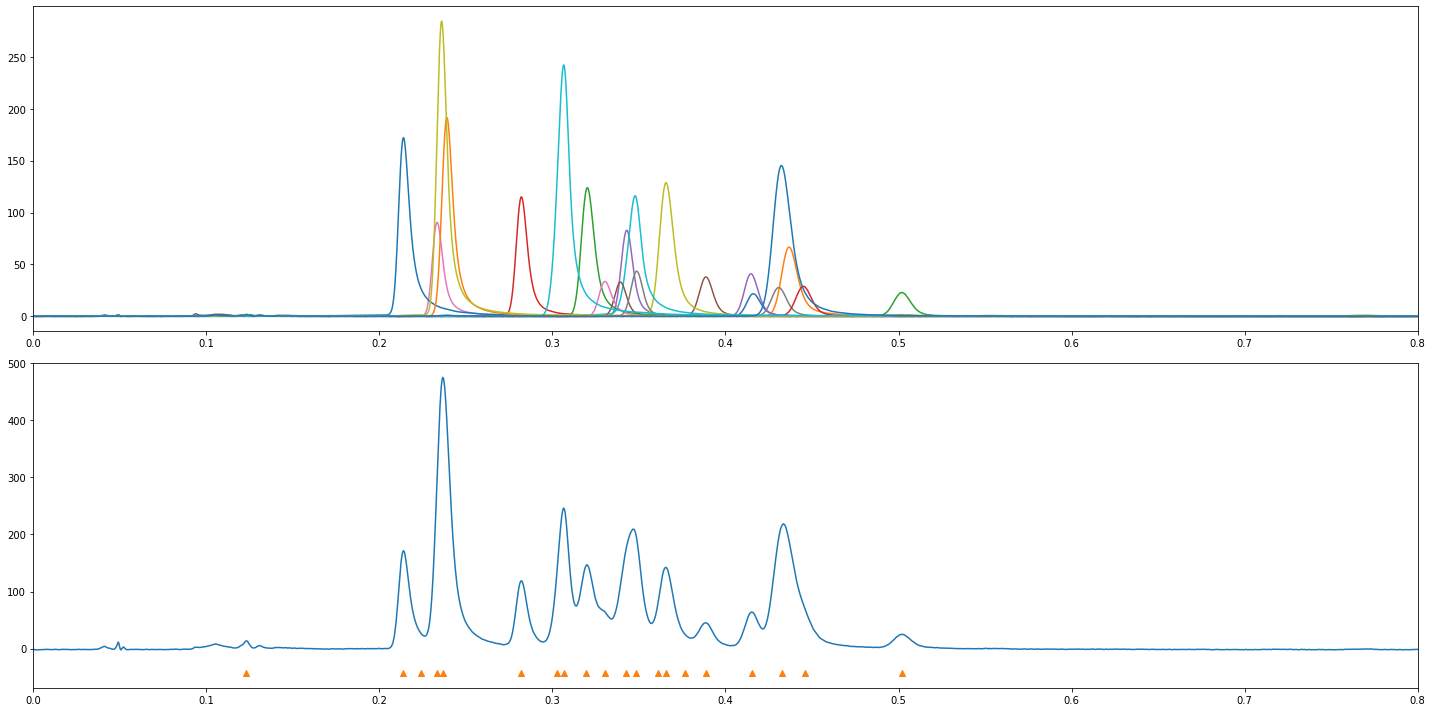

In [19]:
fig, axes = plt.subplots(2,1, figsize=(20, 10))

chromatogram = np.zeros(8192)

for c in glob.glob('../input/ISO10/*.CSV'):
    csv = pd.read_csv(c, header=None, sep='\t', encoding='utf-16')
    d = csv[1].values
    d = apply_interpolation(d, INPUT_SIZE)
    chromatogram += d
    axes[0].plot(np.linspace(0, 1, INPUT_SIZE), d)
    
axes[1].plot(np.linspace(0, 1, INPUT_SIZE), chromatogram)
axes[1].set_xlim(0.0, 0.8)
axes[0].set_xlim(0.0, 0.8)


x = apply_interpolation(chromatogram, INPUT_SIZE)
x_max = x.max()
x = x[None, :, None] / x_max
out = model.predict(x)[0]
x *= x_max

probs, locs, areas = label_encoder.decode(out, 0.5)
for i, (p, l, a) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(l, np.min(x)-40, marker='^', c=f'C1')
    #axes[1].text(x=l, y=-70, s=f'{p:.3f}', rotation=-45)
    #axes[0].axvline(l, c='C1', linestyle=':', linewidth=2)
    #axes[0].axvline(l, c='C1', linestyle=':', linewidth=2)
    

plt.tight_layout()
#plt.savefig('ISO_10_all_compounds.png', dpi=200)

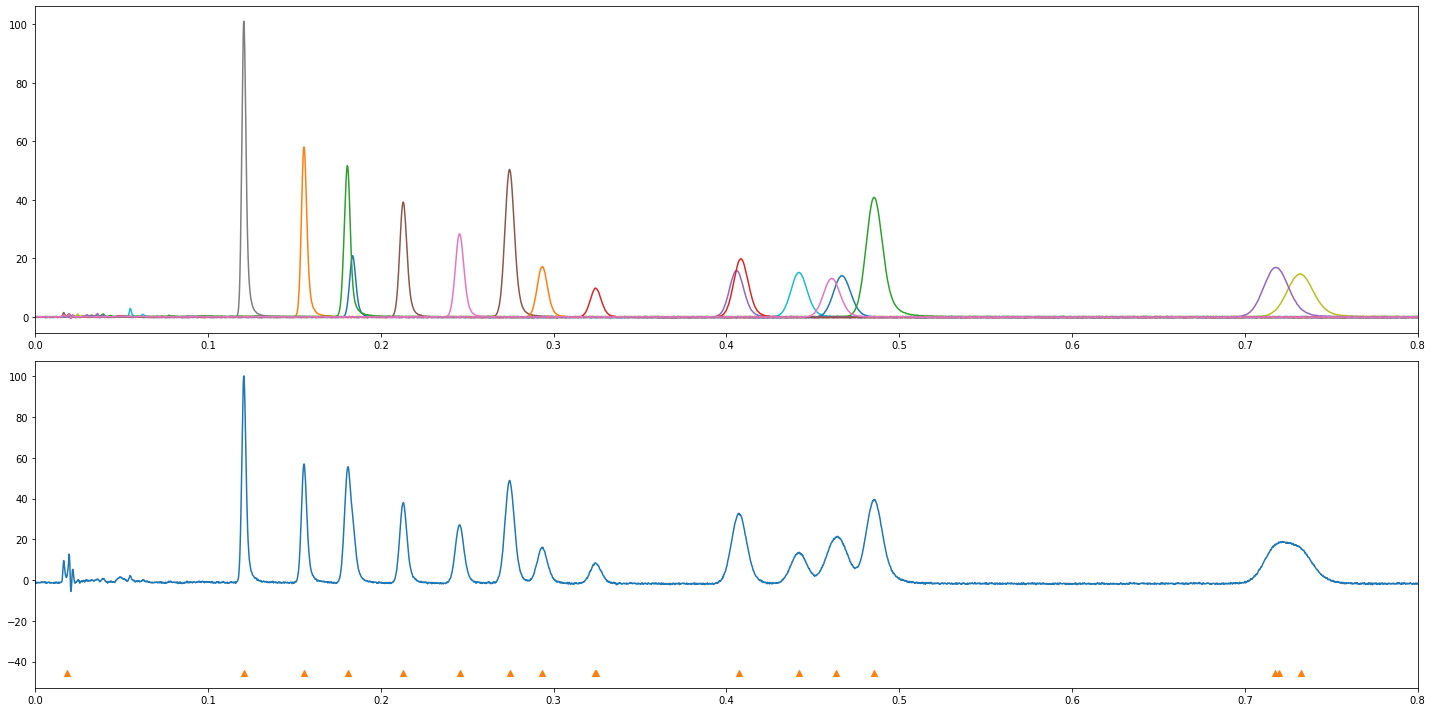

In [14]:
fig, axes = plt.subplots(2,1, figsize=(20, 10))

chromatogram = np.zeros(8192)

for c in glob.glob('../input/ISO40/*.CSV'):
    csv = pd.read_csv(c, header=None, sep='\t', encoding='utf-16')
    d = csv[1].values
    d = apply_interpolation(d, 8192)
    chromatogram += d
    axes[0].plot(np.linspace(0, 1, 8192), d)
    
axes[1].plot(np.linspace(0, 1, 8192), chromatogram)
axes[1].set_xlim(0.0, 0.8)
axes[0].set_xlim(0.0, 0.8)


x = apply_interpolation(chromatogram, 8192)
x_max = x.max()
x = x[None, :, None] / x_max
out = model.predict(x)[0]
x *= x_max

probs, locs, areas = label_encoder.decode(out, 0.4)
for i, (p, l, a) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(l, np.min(x)-40, marker='^', c=f'C1')
    #axes[1].text(x=l, y=-70, s=f'{p:.3f}', rotation=-45)
    #axes[0].axvline(l, c='C1', linestyle=':', linewidth=2)
    #axes[0].axvline(l, c='C1', linestyle=':', linewidth=2)
    

plt.tight_layout()
#plt.savefig('ISO_10_all_compounds.png', dpi=200)

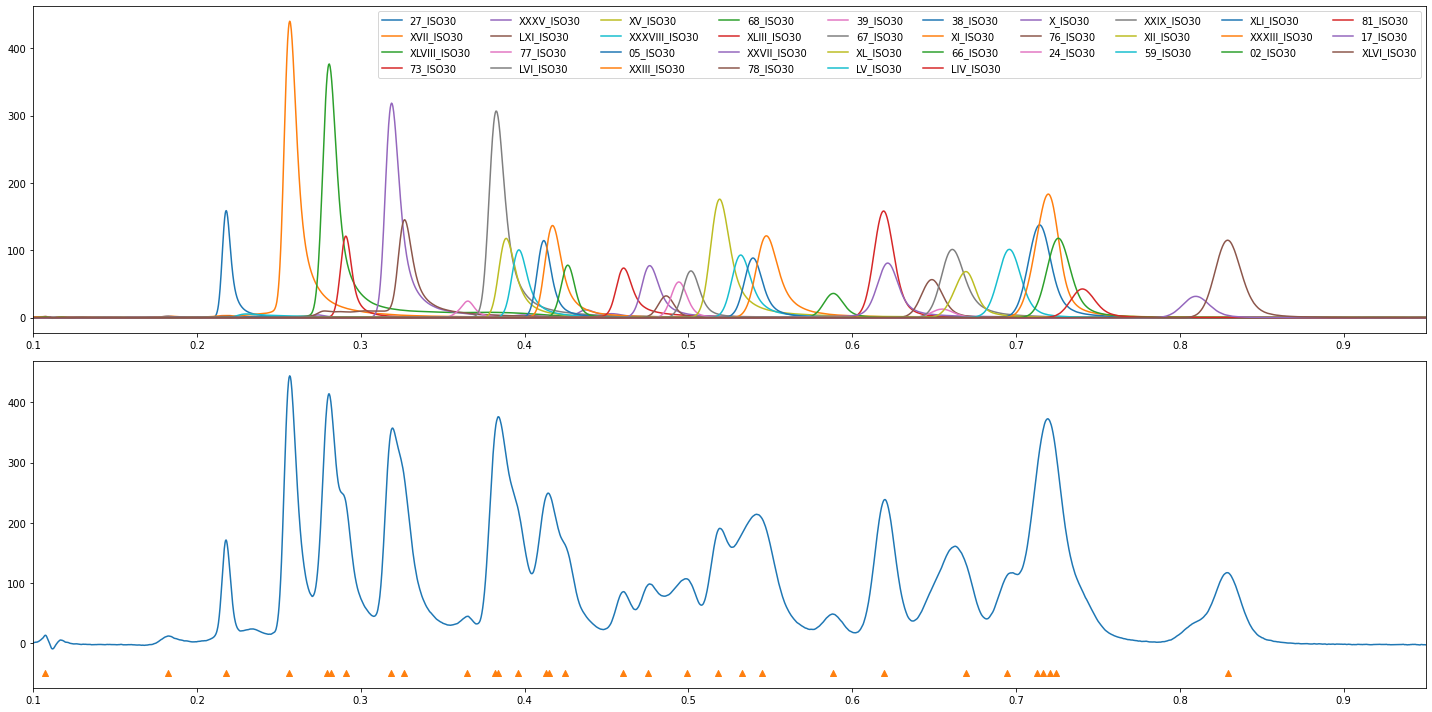

In [15]:
sorted_index = np.array([ 0, 21, 20,  6, 22, 18, 48,  5, 10,  7, 12, 49, 31, 13,  8,  9, 35,
       33, 11, 23, 25, 38, 37, 47, 41, 46, 42,  3, 39, 45,  1,  4, 16, 26,
       24, 17, 14, 34, 29,  2, 19, 40, 28, 44, 30, 27, 32, 36, 15, 43])

fig, axes = plt.subplots(2,1, figsize=(20, 10))

chromatogram = np.zeros(8192)

files = np.array(glob.glob('../input/ISO30/*.CSV'))[sorted_index]
compounds = [f.split('/')[-1].split('.CSV')[0] for f in files]

keep_list = [
    '27_ISO30',    'XVII_ISO30',     'XLVIII_ISO30', '73_ISO30',    
    'XXXV_ISO30',  'LXI_ISO30',    '77_ISO30',      'LVI_ISO30',  
    'XV_ISO30',    'XXXVIII_ISO30',  '05_ISO30',
    'XXIII_ISO30', '68_ISO30',      'XLIII_ISO30',
    'XXVII_ISO30', '78_ISO30',     '39_ISO30',      '67_ISO30',     'XL_ISO30',
    'LV_ISO30',       '38_ISO30',      'XI_ISO30',     '66_ISO30',
    'LIV_ISO30',   'X_ISO30',        '76_ISO30',     '24_ISO30',
    'XXIX_ISO30',  'XII_ISO30',        '59_ISO30',     'XLI_ISO30',
    'XXXIII_ISO30', '02_ISO30',      '81_ISO30',     '17_ISO30',
    'XLVI_ISO30'
]

rt = []
for file, compound in zip(files, compounds):
    
    if compound in keep_list:
        
        csv = pd.read_csv(file, header=None, sep='\t', encoding='utf-16')
        peak = csv[1].values
        peak = apply_interpolation(peak, 8192)
        
        index = np.argmax(peak)
        rt.append(index)
        chromatogram += peak
        axes[0].plot(np.linspace(0, 1, 8192), peak, label=compound)
        
axes[1].plot(np.linspace(0, 1, 8192), chromatogram)
axes[1].set_xlim(0.1, 0.95)
axes[0].set_xlim(0.1, 0.95)
axes[0].legend(ncol=10)


x = apply_interpolation(chromatogram, 8192)
x_max = x.max()
x = x[None, :, None] / x_max
out = model.predict(x)[0]
x *= x_max

probs, locs, areas = label_encoder.decode(out, 0.6)
for i, (p, l, a) in enumerate(zip(probs, locs, areas)):
    axes[1].scatter(l, np.min(x)-40, marker='^', c=f'C1')
    #axes[1].text(x=l, y=-70, s=f'{p:.3f}', rotation=-45)
    #axes[0].axvline(l, c='C1', linestyle=':', linewidth=2)
    #axes[0].axvline(l, c='C1', linestyle=':', linewidth=2)


plt.tight_layout()




In [16]:
# import scipy.signal

# plt.figure(figsize=(80, 8))
# deriv = scipy.signal.savgol_filter(x, window_length=51, polyorder=2, deriv=2)

# plt.plot(x[2000:7000] * 0.001)
# plt.plot(deriv[2000:7000])

In [17]:
# plt.figure(figsize=(60, 10))


# csv = pd.read_csv('../input/chrom_1/GRA_ALL_F160.CSV', header=None, sep='\t', encoding='utf-16')
# x = csv[1].values
# x = apply_interpolation(x, 16384)
# x_max = x.max()
# x = x[None, :, None] / x_max
# out = model.predict(x)[0]

# for c in glob.glob('../input/chrom_1/GRA_[0-9]*'):
#     csv = pd.read_csv(c, header=None, sep='\t', encoding='utf-16')
#     d = csv[1].values
#     d = apply_interpolation(d, 16384)
#     d = d / x_max
#     plt.plot(d)
    
    
# probs, locs, areas = label_encoder.decode(out, 0.5)
# for i, (p, l, a) in enumerate(zip(probs, locs, areas)):
#    # print(p, l, a)
#     plt.scatter(l * 16384, np.min(x)-0.2, c=f'C{i}', label=f'{p:.2f}')
#     #plt.text(x=l * 16384, y=np.min(x)-0, s=f'{p:.2f}', rotation=-45)
#     #plt.plot([l-w/2, l+w/2], [.080+(i*.015), .080+(i*.015)], color=f'C{i}')
#     #plt.plot([l, l], [0, a], color='C0', linewidth=4, linestyle=':')
#     #plt.plot([l-s/2, l+s/2], [0, 0], color='C0', linewidth=4, linestyle=':')
    
#     #index = int(g * 16384)
#     #height = max(x[index-10:index+10]) + 20
#     #plt.text(x=g-0.005, y=height, s=f"{a:.2f}", color='C1', fontsize=14)

# plt.legend(loc=2, ncol=10)
# plt.plot(x[0, :, 0], c='black', linestyle='--')
